In [1]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy
config.update("jax_platform_name", 'cpu') # use cpu if needed

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

import dlib
import cv2
import math

In [2]:
#load attributes csv file
path_csv  = "D:\\Academics\\DSA\\4212\\datasets" # Local Path (Change Here)
# path_csv  = '/content/gdrive/My Drive/DSA4212/datasets' # Google Drive
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))

In [3]:
#let us list all the files in the image directory
path = "D:\\Academics\\DSA\\4212\\datasets\\img_celeba_small" # Local Path (Change Here)
# path = "/content/img_celeba_small" # Google Drive
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


In [ ]:
%%capture --no-display
url = "https://raw.githubusercontent.com/sightmachine/SimpleCV/master/SimpleCV/Features/HaarCascades/"
facial_parts = ['face', 'eye', 'mouth', 'nose']
for p in facial_parts:
    p_file = p + '.xml'
    p_url = url + p_file
    !wget {p_url}

In [30]:
# Feature extraction

def find_vertex(all_img):
    """
    find the average vertex of face, eyes, mouth and nose among all imgs

    args:
    fnames: file names of the image to be loaded (a list)
    
    output: A dictionary in the form of {face:(x,y,h,w); nose:(x,y,h,w); mouth:(x,y,h,w), eyes:(x,y,h,w) }
    """
    face_cascade = cv2.CascadeClassifier("face.xml")
    eye_cascade = cv2.CascadeClassifier("eye.xml")
    nose_cascade = cv2.CascadeClassifier("nose.xml")
    mouth_cascade = cv2.CascadeClassifier("mouth.xml")
    face_found = []
    eyes_found = []
    nose_found = []
    mouth_found = []
    
    start = time.time()
    for k in range(len(all_img)):
        #load image
        img = cv2.imread(os.path.join(path, all_img[k]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(img)
        eyes = eye_cascade.detectMultiScale(img)
        nose = nose_cascade.detectMultiScale(img)
        mouth = mouth_cascade.detectMultiScale(img)

        not_found = np.array([[np.nan]])

        face_found.append(faces) if faces != () else face_found.append(not_found)
        eyes_found.append(eyes) if eyes != () else eyes_found.append(not_found)
        nose_found.append(nose) if nose != () else nose_found.append(not_found)
        mouth_found.append(mouth) if mouth != () else  mouth_found.append(not_found)
        
        if k % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images extracted: {k}, Time elapsed: {duration:.2f}")
    
    
    output = {}    

    temp = [x[0] for x in onp.squeeze(face_found)]
    face_vertex = pd.DataFrame(temp)
    [x,y,h,w] = face_vertex.dropna().mean()
    output["face"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(nose_found)]
    nose_vertex = pd.DataFrame(temp)
    [x,y,h,w] = nose_vertex.dropna().mean()
    output["nose"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(eyes_found)]
    eyes_vertex = pd.DataFrame(temp)
    [x,y,h,w] = eyes_vertex.dropna().mean()
    output["eyes"] = [x,y,h,w]

    temp = [x[0] for x in onp.squeeze(mouth_found)]
    mouth_vertex = pd.DataFrame(temp)
    [x,y,h,w] = mouth_vertex.dropna().mean()
    output["mouth"] = [x,y,h,w]
    
    return output


def image_area_loader(all_img,vertex,gray = False):
    """
    Load Images by area(face, mouth, nose, eyes)

    args:
    fnames: file names of the image to be loaded (a list)
    vertex: vertex (x,y,h,w) that the image to be loaded
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    """
    ceil = [math.ceil(v) for v in vertex ]
    size = len(all_img)
    [x,y,w,h] = ceil
    start = time.time()
    
    if gray == True:
        img_set= onp.zeros((size, h,w))

        for k in range(size):
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = im[y:y+h,x:x+w,:]
            im = onp.mean(im, axis=2)
            img_set[k,:,:] = im
            
            if k % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {k}, Time elapsed: {duration:.2f}")
    else:
        img_set= onp.zeros((size, h,w,3))

        for k in range(size):
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = im[y:y+h,x:x+w,:]
            img_set[k,:,:,:] = im
            
            if k % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {k}, Time elapsed: {duration:.2f}")
    
    return img_set

In [5]:
# Predict P(Y=1|X, Beta)
@jax.jit
def pred_proba(beta, x):
    """ predict the probability that label is +1 given x and beta """
    return 1. / (1. + jnp.exp(-jnp.dot(beta, x)))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [6]:
@jax.jit
def get_label(p, threshold=0.5):
    pred_bool = p > threshold
    pred_label = 2*pred_bool - 1
    return pred_label

def get_accuracy(p, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==get_label(p))

from sklearn.metrics import roc_auc_score

def get_auc(p, Y):
    return roc_auc_score(p, Y)

def test_acc(beta,Y_true, test_img_arr):
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    return test_acc

def test_auc(beta,Y_true, test_img_arr):
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_auc = get_auc(Y_true, test_pred)
    return test_auc

In [7]:
def test_acc_auc(beta, Y_true, test_img_arr):
    """
    Get the accuracy and AUC-ROC score for test data
     beta: Model Parameters
     Y_true: Ground truth labels
     test_img_arr: test images represented by an array
    """
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    test_auc = get_auc(Y_true, test_pred)
    
    print(f'Test Accuracy is {test_acc:.2f}')
    print(f'Test AUC is {test_auc:.2f}')
    
    return test_acc, test_auc

## Utility Functions for Basic Logistic Regression

In [8]:
@jax.jit
def loss_single(beta, x, y):
    """ logistic regression loss on a single image """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))
loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0)) # Vectorize Loss Function

In [9]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

## Utility Functions for Regularized Logistic Regression (Ridge, Lasso, ...)

In [38]:
### Ridge
@jax.jit
def loss_ridge(beta, X, Y, lambda_ridge=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_ridge: ridge parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = jnp.sum(loss_batch(beta, X, Y))
    loss_batch_ridge = loss_original + lambda_ridge*jnp.sum(beta**2)

    return loss_batch_ridge/len(Y)

# compute derivates
loss_ridge_grad = jax.jit(jax.grad(loss_ridge, argnums=0))
loss_ridge_values_and_grad = jax.jit(jax.value_and_grad(loss_ridge, argnums=0))

In [41]:
@jax.jit
def loss_lasso(beta, X, Y, lambda_lasso=0.5):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
     lambda_lasso: lasso parameter, default 0.5
    """
    # compute all the individual losses
    loss_original = jnp.sum(loss_batch(beta, X, Y))
    loss_batch_lasso = loss_original + lambda_lasso*jnp.sum(jnp.abs(beta))

    return loss_batch_lasso/len(Y)

# compute derivates
loss_lasso_grad = jax.jit(jax.grad(loss_lasso, argnums=0))
loss_lasso_values_and_grad = jax.jit(jax.value_and_grad(loss_lasso, argnums=0))

## Utility Functions for Training Model and Backcalling

In [51]:
## with fixed mom_constant
def train_SGD_mom(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100, mom_constant=0.5):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD plus momentum
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     mom_constant: choise of momentum constant, default 0.5

    Outputs:
     beta: The final updated values of beta
     record: A dictionary of performance during training, including 'loss_epoch', 'loss_mb', 'test_acc_epoch', 'test_acc_mb' 
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_epoch = []
    loss_history_mb = []
    test_acc_history_epoch = []
    test_acc_history_mb = []
    
    beta = np.copy(beta_init)
    beta_old = np.copy(beta_init)
    learning_rate = lr
    
    np.random.seed(42)

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        all_acc_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            mom = beta - beta_old
            beta_old = beta
            beta = beta - learning_rate*grad + mom_constant*mom


            # book-keeping
            loss_history_mb.append(val)
            all_loss_within_epoch.append(val)
            
            test_acc_mb = test_acc(beta, test_label, test_img_arr)
            test_acc_history_mb.append(test_acc_mb)
            all_acc_within_epoch.append(test_acc_mb)
            
        loss_epoch = np.mean(all_loss_within_epoch)
        loss_history_epoch.append(loss_epoch)
        
        test_acc_epoch = np.mean(all_acc_within_epoch)
        test_acc_history_epoch.append(test_acc_epoch)
        
        end = time.time()
        duration = end - start
        

        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_epoch:.2f}, Test Accuracy: {test_acc_epoch:.3f}")
            
    record = {'name': "Momentum",
              'loss_epoch': loss_history_epoch,
              'loss_mb': loss_history_mb,
              'test_acc_epoch': test_acc_history_epoch,
              'test_acc_mb': test_acc_history_mb}
    
    return beta, record

## Utility Functions for Plotting Graph

In [13]:
def plot_loss(loss_history):
    plt.plot(loss_history, "-^")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.grid(True)

In [14]:
def record_graph(record_list, key='test_acc_epoch', n = None):
    """
    Plot graph of records in the list
    
    Args:
     record_list: List of record (dictionary) as returned by model training functions
     key: Performance metric to be plotted
     n: Number of results to be plotted, full results will be plotted if None
     
    Output:
     Multiple lines of the record on the same graph
    """
    keys = record_list[0].keys()
    if key not in keys:
        print(f'{key} is an invalid key!')
        print(f'Please enter one of the following: {keys}')
        
    plt.figure(figsize=(16,10))
        
    for record in record_list:
        if n == None:
            n = len(record.get(key))
        y = record.get(key)[:n]
        x = np.arange(n)
        plt.xticks(x)
        plt.plot(x,
                 y, 
                 "-.",
                 alpha=0.6,
                 label=record.get('name'))
    
    plt.legend()
    plt.xlabel(f'{key}'.split('_')[-1])
    plt.ylabel(' '.join(f'{key}'.split('_')[:-1]))
    plt.grid(True)
    plt.title("Summary of Results");

In [15]:
test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)

train_small_img = all_img[:200]
train_small_label = attribute['Male'][:200]
train_small_label = np.array(train_small_label).reshape(-1)

In [16]:
import gc
def clear_image_cache(var_list):
    for var in var_list:
        if var in globals().keys():
            del globals()[var]
    gc.collect()
    time.sleep(1)
# del test_img_arr
# del train_img_arr

In [22]:
vertex = find_vertex(all_img)

<ipython-input-20-56738e2eaf7c>:33: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  face_found.append(faces) if faces != () else face_found.append(not_found)
<ipython-input-20-56738e2eaf7c>:34: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  eyes_found.append(eyes) if eyes != () else eyes_found.append(not_found)
<ipython-input-20-56738e2eaf7c>:35: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  nose_found.append(nose) if nose != () else nose_found.append(not_found)
<ipython-input-20-56738e2eaf7c>:36: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mouth_found.append(mouth) if mouth != () else  mouth_found.append(not_found)


Number of images extracted: 0, Time elapsed: 0.77
Number of images extracted: 1000, Time elapsed: 64.42
Number of images extracted: 2000, Time elapsed: 148.41
Number of images extracted: 3000, Time elapsed: 240.61
Number of images extracted: 4000, Time elapsed: 333.87
Number of images extracted: 5000, Time elapsed: 423.12
Number of images extracted: 6000, Time elapsed: 508.97
Number of images extracted: 7000, Time elapsed: 600.39
Number of images extracted: 8000, Time elapsed: 688.99
Number of images extracted: 9000, Time elapsed: 781.69
Number of images extracted: 10000, Time elapsed: 876.87
Number of images extracted: 11000, Time elapsed: 970.29
Number of images extracted: 12000, Time elapsed: 1061.60
Number of images extracted: 13000, Time elapsed: 1154.85
Number of images extracted: 14000, Time elapsed: 1246.10
Number of images extracted: 15000, Time elapsed: 1340.58
Number of images extracted: 16000, Time elapsed: 1441.91
Number of images extracted: 17000, Time elapsed: 1543.83
Nu

C:\Users\z9906\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [31]:
face_train = image_area_loader(train_small_img, vertex['face']).reshape(-1, 3 * 104 * 104)
face_test =  image_area_loader(test_img, vertex['face']).reshape(-1, 3 * 104 * 104)

Number of images imported: 0, Time elapsed: 0.00
Number of images imported: 0, Time elapsed: 0.00
Number of images imported: 1000, Time elapsed: 1.05
Number of images imported: 2000, Time elapsed: 2.09
Number of images imported: 3000, Time elapsed: 3.17
Number of images imported: 4000, Time elapsed: 4.24


In [67]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / 104
face_beta_init = np.random.normal(0,beta_standard_dev,3*104*104)

test_img_arr = face_test

In [76]:
beta_face, record_face = train_SGD_mom(
    face_train, train_small_label, face_beta_init, 1e-6, loss_LR_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.77 seconds, Loss: 52.52, Test Accuracy: 0.517
Epoch 1: 0.76 seconds, Loss: 34.81, Test Accuracy: 0.573
Epoch 2: 0.81 seconds, Loss: 37.63, Test Accuracy: 0.599
Epoch 3: 0.79 seconds, Loss: 31.04, Test Accuracy: 0.606
Epoch 4: 0.95 seconds, Loss: 27.50, Test Accuracy: 0.624
Epoch 5: 0.79 seconds, Loss: 22.89, Test Accuracy: 0.595
Epoch 6: 0.78 seconds, Loss: 15.60, Test Accuracy: 0.644
Epoch 7: 0.94 seconds, Loss: 17.16, Test Accuracy: 0.650
Epoch 8: 0.86 seconds, Loss: 6.92, Test Accuracy: 0.734
Epoch 9: 0.82 seconds, Loss: 25.85, Test Accuracy: 0.624
Epoch 10: 0.76 seconds, Loss: 25.77, Test Accuracy: 0.626
Epoch 11: 0.69 seconds, Loss: 9.17, Test Accuracy: 0.692
Epoch 12: 0.85 seconds, Loss: 7.61, Test Accuracy: 0.717
Epoch 13: 0.83 seconds, Loss: 5.00, Test Accuracy: 0.762
Epoch 14: 0.93 seconds, Loss: 25.72, Test Accuracy: 0.610
Epoch 15: 2.21 seconds, Loss: 8.82, Test Accuracy: 0.739
Epoch 16: 1.59 seconds, Loss: 10.46, Test Accuracy: 0.660
Epoch 17: 1.48 seconds, Loss:

In [74]:
test_img_arr = face_test

beta_lasso_face, record_lasso_face = train_SGD_mom(
    face_train, train_small_label, face_beta_init, 1e-6, loss_lasso_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.76 seconds, Loss: 54.76, Test Accuracy: 0.517
Epoch 1: 0.71 seconds, Loss: 37.05, Test Accuracy: 0.573
Epoch 2: 0.77 seconds, Loss: 39.94, Test Accuracy: 0.599
Epoch 3: 0.68 seconds, Loss: 33.15, Test Accuracy: 0.605
Epoch 4: 0.69 seconds, Loss: 22.81, Test Accuracy: 0.602
Epoch 5: 0.68 seconds, Loss: 54.98, Test Accuracy: 0.651
Epoch 6: 0.69 seconds, Loss: 34.38, Test Accuracy: 0.606
Epoch 7: 0.68 seconds, Loss: 39.35, Test Accuracy: 0.609
Epoch 8: 0.70 seconds, Loss: 8.47, Test Accuracy: 0.738
Epoch 9: 0.80 seconds, Loss: 27.54, Test Accuracy: 0.625
Epoch 10: 0.72 seconds, Loss: 24.41, Test Accuracy: 0.645
Epoch 11: 0.71 seconds, Loss: 9.49, Test Accuracy: 0.706
Epoch 12: 0.68 seconds, Loss: 8.14, Test Accuracy: 0.727
Epoch 13: 0.69 seconds, Loss: 13.07, Test Accuracy: 0.695
Epoch 14: 0.69 seconds, Loss: 19.77, Test Accuracy: 0.642
Epoch 15: 0.69 seconds, Loss: 11.82, Test Accuracy: 0.701
Epoch 16: 0.70 seconds, Loss: 8.33, Test Accuracy: 0.718
Epoch 17: 0.69 seconds, Loss

In [75]:
test_img_arr = face_test

beta_ridge_face, record_ridge_face = train_SGD_mom(
    face_train, train_small_label, face_beta_init, 1e-6, loss_ridge_values_and_grad, n_epoch = 20, mb_size = 32, verbose = 1)

Epoch 0: 0.76 seconds, Loss: 52.54, Test Accuracy: 0.517
Epoch 1: 0.78 seconds, Loss: 34.82, Test Accuracy: 0.573
Epoch 2: 0.74 seconds, Loss: 37.65, Test Accuracy: 0.599
Epoch 3: 0.72 seconds, Loss: 31.05, Test Accuracy: 0.606
Epoch 4: 0.70 seconds, Loss: 27.50, Test Accuracy: 0.623
Epoch 5: 0.76 seconds, Loss: 10.90, Test Accuracy: 0.670
Epoch 6: 0.77 seconds, Loss: 12.51, Test Accuracy: 0.652
Epoch 7: 0.77 seconds, Loss: 15.10, Test Accuracy: 0.676
Epoch 8: 0.81 seconds, Loss: 8.18, Test Accuracy: 0.688
Epoch 9: 0.75 seconds, Loss: 30.20, Test Accuracy: 0.614
Epoch 10: 0.71 seconds, Loss: 24.43, Test Accuracy: 0.669
Epoch 11: 0.72 seconds, Loss: 15.81, Test Accuracy: 0.643
Epoch 12: 0.70 seconds, Loss: 7.33, Test Accuracy: 0.711
Epoch 13: 0.73 seconds, Loss: 15.13, Test Accuracy: 0.646
Epoch 14: 0.70 seconds, Loss: 10.58, Test Accuracy: 0.722
Epoch 15: 0.70 seconds, Loss: 15.37, Test Accuracy: 0.632
Epoch 16: 0.71 seconds, Loss: 15.31, Test Accuracy: 0.673
Epoch 17: 0.70 seconds, Lo

In [71]:
record_face['name'] = 'Momentum_LR'
record_lasso_face['name'] = 'Momentum_Lasso'
record_ridge_face['name'] = 'Momentum_Ridge'

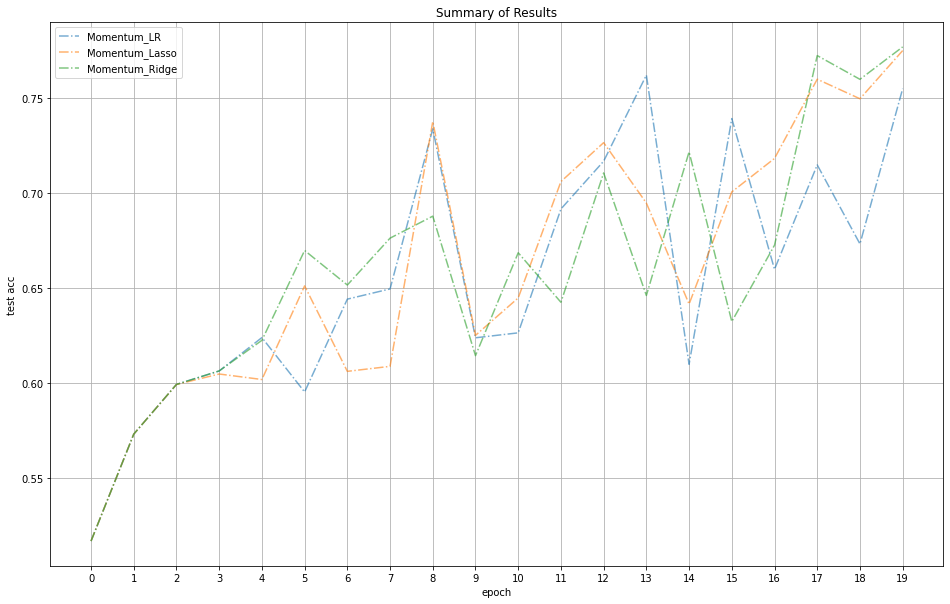

In [72]:
record_list = [record_face, record_lasso_face, record_ridge_face]

record_graph(record_list, 'test_acc_epoch')
# plt.savefig("small_test.jpg")

In [60]:
auc_LR = test_auc(beta_face, test_label, test_img_arr)
auc_Lasso = test_auc(beta_lasso_face, test_label, test_img_arr)
auc_Ridge = test_auc(beta_ridge_face, test_label, test_img_arr)

print(f'Test ROC-AUC w/o regularization: {auc_LR:.5f}')
print(f'Test ROC-AUC with LASSO: {auc_Lasso:.5f}')
print(f'Test ROC-AUC with Ridge: {auc_Ridge:.5f}')